# 핸즈온 머신러닝 Chap 3. 분류
## 3.1 MNIST
---

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- DESCR 키: 데이터셋을 설명
- data 키: 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열
- target 키: 레이블 배열

In [ ]:
X, y = mnist['data'], mnist['target']

In [ ]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


=> 70,000개의 이미지, 각 이미지에는 784개의 특성이 있다. (이미지가 28*28 픽셀이기 때문)

개개의 특성: 0(흰색) ~ 255(검은색) 픽셀 강도


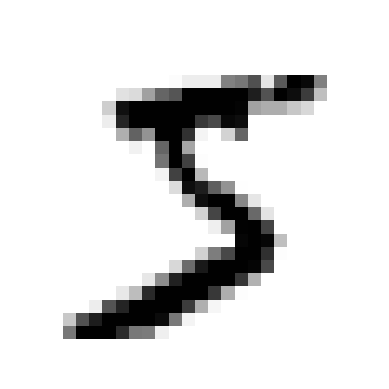

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 28x28 배열로 크기 변
some_digit = X[0]
some_digit_image= np.array(some_digit).reshape(28,28)

# 맷플롯립의 imshow()함수 사용
plt.imshow(some_digit_image,cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
# 실제 레이블 확인
y[0]

'5'

In [ ]:
# 레이블은 문자열인데 대부분 머신러닝 알고리즘은 숫자를 기대하므로
# y를 정수로 변환
y = y.astype(np.uint8)

- 데이터를 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어놓아야 한다.

(MNIST 데이터셋은 이미 훈련 세트(앞쪽 60,000개의 의미지)와 테스트 세트(뒤쪽 10,000개의 이미지)로 나누어 놓음)

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

훈련 세트는 이미 섞여 있어서 모든 교차 검증 폴드를 비슷하게 만든다.
어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠진다.

=> 데이터셋을 섞으면 성능 저하를 방지할 수 있다.

## 3.2 이진 분류기 훈련
---

이진 분류기: 두 개의 클래스를 구분
- 분류 작업을 위한 타깃 벡터 만들기

In [ ]:
y_train_5 = (y_train ==5) # 5는 True이고, 다른 숫자는 모두 False
y_test_5 = (y_test ==5)

- 분류 모델 하나 선택해서 훈련시키기

사이킷런의 SGBClassifier 클래스 사용하여 확률적 경사 하강법(SGD) 분류기로 시작

확률적 경사 하강법(SGD) 분류기: 매우 큰 데이터셋을 효율적으로 처리하는 장점 (한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문)


In [ ]:
# SGBClassifier 모델 만들고, 전체 훈련 세트 사용해 훈련
from sklearn.linear_model import SGDClassifier # SGBClassifier는 훈련하는 데 무작위성 사용
sgd_clf = SGDClassifier(random_state=42) # 결과를 재현하려면 random_state 매개변수 지정 필요
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
# 모델 사용해 숫자 5의 의미지 감지
sgd_clf.predict([some_digit])

array([ True])

=> 분류기는 이 이미지가 5를 나타낸다고 추측했다 (True).

## 3.3 성능 측정
---

### 3.3.1 교차 검증을 사용한 정확도 측정

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # 0.9669, 0.91625, 0.96785 출력

0.9669
0.91625
0.96785


- StratifiedKFold: 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행

매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만들고, 올바른 예측의 수를 세어 정확한 예측의 비율 출력

- cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델 평가

k-겹 교차 검증: 훈련 세트를 k개(여기서는 3개)의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용한다.

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train,y_train_5, cv=3 , scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

=> 모든 교차 검증 폴드에 대한 정확도(정확한 예측의 비율)가 95% 이상이다.

- 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self,X,y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1), dtype= bool)

- 모델의 정확도 추측

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

=> 정확도가 90% 이상으로 나왔다.

=> 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여주는 예시!!
  (특히 불균형한 데이터셋을 다룰 때)

### 3.3.2 오차 행렬

분류기의 성능을 평가하는 더 좋은 방법은 오차 행렬을 조사하는 것이다.

기본적 아이디어: 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것

- 오차 행렬을 만들려면 실제 타킷과 비교할 수 있도록 먼저 예측값을 만들어야 한다.

In [ ]:
from sklearn.model_selection import cross_val_predict
# cross_val_predict: 평가 점수를 반환하지 않고, 각 테스트 폴드에서 얻은 예측을 반환

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- 오차 행렬의 행은 **실제 클래스**, 열은 **예측한 클래스**를 나타낸다.

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
y_train_perfect_predictions = y_train_5  # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

# 완벽한 분류기라면 오차 행렬의 주대각선(왼쪽 위에서 오른쪽 아래로)만 0이 아닌 값이 된다.

array([[54579,     0],
       [    0,  5421]])

### 3.3.3 정밀도와 재현율

- 정밀도: 양성 예측의 정확도


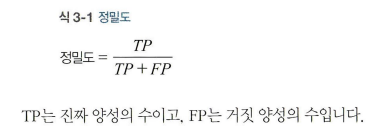

- 재현율: 분류기가 정확하게 감지한 양성 샘플의 비율 (= 민감도, 진짜 양성 비율(TPR))


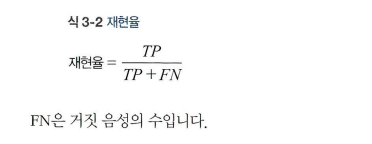

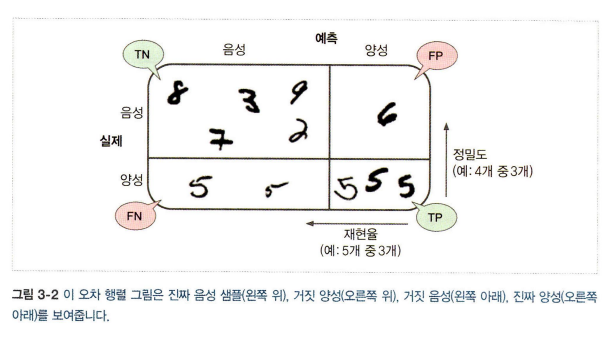

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

- F1 점수: 정밀도와 재현율의 조화 평균

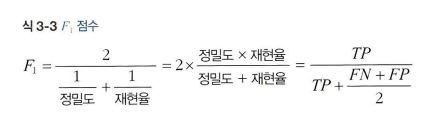

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

=> 정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높다.

(상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있으므로 이게 항상 바람직한 것은 아님)

### 3.3.4 정밀도/재현율 트레이드오프

: 정밀도를 올리면 재현율이 줄고, 그 반대도 마찬가지인 것.

- SGCClassifier 분류기: 결정 함수를 사용하여 각 샘플의 점수 계산. 이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당, 그렇지 않으면 음성 클래스에 할당.

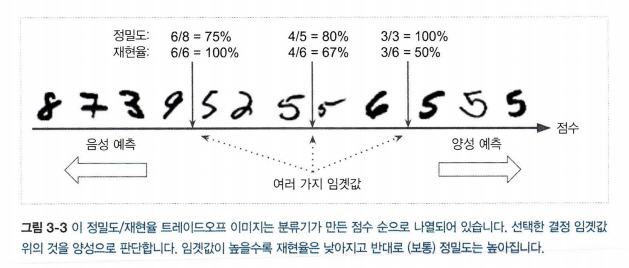

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])  # 각 샘플의 점수 확인
y_scores

array([2164.22030239])

In [ ]:
threshold=0  # 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만든다
y_some_digit_pred = (y_scores> threshold)
y_some_digit_pred

array([ True])

In [ ]:
# 임곗값을 높여보자
threshold= 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [ ]:
# 훈련 세트에 있는 모든 샘플의 점수 구하기
# 예측 결과가 아닌 결정 점수를 반환받도록 지정
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3 ,
                             method = "decision_function")

In [ ]:
# 이 점수로 가능한 모든 임계값에 대해 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

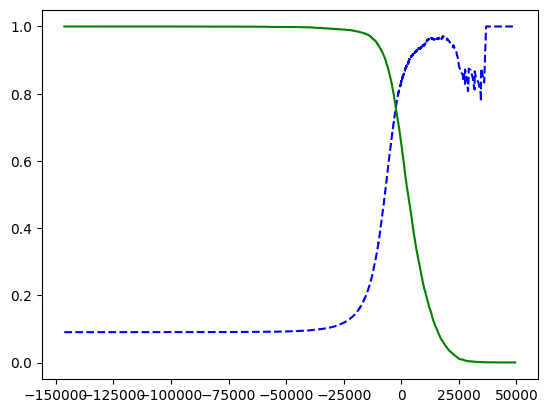

In [ ]:
# 맷플롯립을 이용해 임곗값의 함수로 정밀도와 재현율 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
  [...] # 임곗값을 표시하고 범례, 축 이름, 그리드를 추가

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:
# 조금 더 정확하게 최소한 90% 정밀도가 되는 가장 낮은 임곗값 찾기
# np.argmax는 최댓값의 첫 번째 인덱스를 반환
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision  # 첫 번째 True 값을 의미

3370.0194991439557

In [ ]:
# 훈련 세트에 대한 예측을 만들려면 predict() 메서드를 호출하는 대신 다음 코드를 실행
y_train_pred_90=(y_scores >= threshold_90_precision)

In [ ]:
# 이 예측에 대한 정밀도와 재현율 확인
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


=> 정밀도 90%를 달성한 분류기를 만들었다.

=> 어떤 가상의 정밀도에 대해서도 분류기를 손쉽게 만들 수 있다. 충분히 임곗값을 지정하면 끝.

(BUT, 재현율이 너무 낮다면 높은 정밀도의 분류기는 전혀 유용하지 않다.)

### 3.3.5 ROC 곡선

수신기 조작 특성(ROC) 곡선: 이진 분류에 사용. 정밀도/재현율 곡선과 비슷하지만,

 ROC 곡선은 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)의 곡선.

 (1에서 진짜 음성 비율(TNR=특이도)을 뺀 값).

> ROC = (1-특이도) / 민감도(재현육)


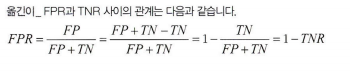

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

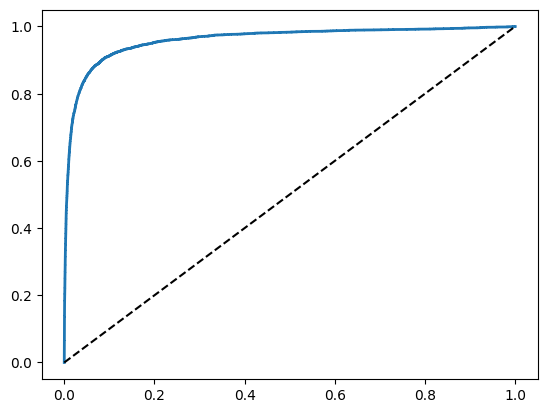

In [ ]:
# 맷플롯립을 사용해 TPR에 대한 FPR 곡선 그리기
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1],'k--')  # 대각 점선
  [...]  # 축 이름, 그리드 추가

plot_roc_curve(fpr, tpr)
plt.show()

=> 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성이 늘어난다. (트레이드오프)

점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻함 => 좋은 분류기는 점선에서 최대한 멀리 떨어져 있어야 한다(왼쪽 위 모서리).

In [ ]:
# 곡선 아래의 면적(AUC) 측정해 분류기들 비교
## 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [ ]:
# RandomForestClassifier 훈련시켜 SGDClassifier의 ROC곡선과 ROC AUC점수와 비교

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:,1] #양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

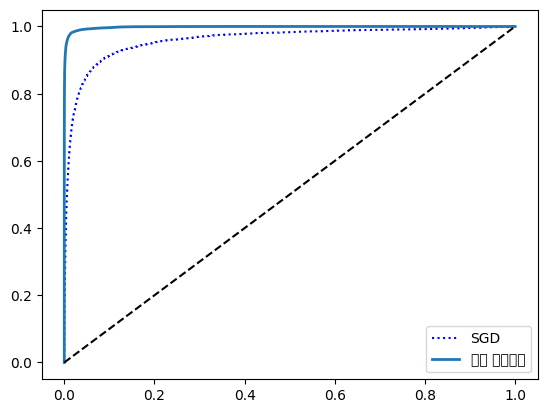

In [ ]:
# 비교를 위해 첫 번째 ROC 곡선도 함께 그림
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

=> 랜덤 포레스트 분류기가 SGD 분류기보다 훨씬 좋다.

In [ ]:
# ROC AUC 점수도 훨씬 높다
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## 3.4 다중 분류
---

다중 분류기(다항 분류기): 둘 이상의 클래스 구별

- SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이지 분류기 등 -> 여러 개의 클래스 직접 처리
-  로지스틱 회귀, 서포트 벡터 머신 분류기 등 -> 이진 분류만 가능
- 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많음.


In [ ]:
# 서포트 벡터 머신 분류기 테스트
from sklearn.svm import SVC
svm_clf= SVC()
svm_clf.fit(X_train, y_train) # y_train_5가 아니고 y_train을 사용
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
# 샘플 당 10개의 점수 반환 (점수는 클래스마다 하나씩)
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([2164.22030239])

In [ ]:
np.argmax(some_digit_scores)

0

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
# 가장 높은 점수가 클래스 5에 해당하는 값
svm_clf.classes_[5]

5

In [ ]:
# SVC 기반으로 OvR 전략 사용하는 다중 분류기 만들기
from sklearn.multiclass import OneVsOneClassifier

ovr_clf = OneVsOneClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

45

In [ ]:
# SGDClassifier 훈련
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
# SGD 분류기가 클래스마다 부여한 점수 확인
## decision_function(): 클래스마다 하나의 값 반환
sgd_clf.decision_function([some_digit])

In [ ]:
# 교차 검증 사용해 분류기 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
# 성능을 더 높이기 위해 StandardScaler 이용해 입력 스케일 조정
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 에러분석
---

에러의 종류 분석: 가능성이 높은 모델을 하나 찾았다고 가정하고, 이 모델의 성능을 향상시킬 방법

In [ ]:
# cross_val_predict() 함수 이용해 예측 만들고, confusion_matrix() 함수 호출
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

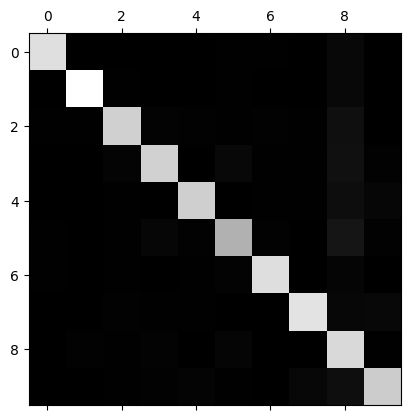

In [ ]:
# 오차 행렬을 맷플롯립의 matshow() 함수 사용해 이미지로 표현 -> 보기에 편리하기 위함
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

=> 이 오차 행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아 보인다.

=> 숫자 5가 다른 숫자보다 조금 더 어두워 보이는 이유: 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻

=> 두 경우에 대해 모두 확인해 보아야 함.

- 그래프의 에러 부분에 초점 맞추기

오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율 비교 (개수로 비교 X)

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

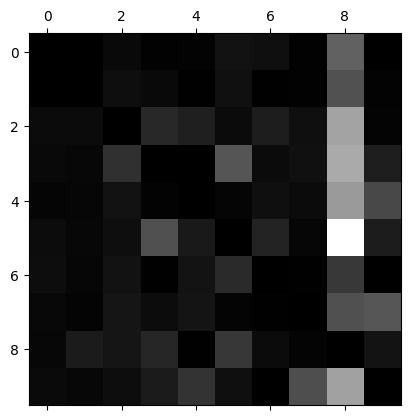

In [ ]:
# 다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프 그리기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
# 맷플롯립의 imshow() 사용하는 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")



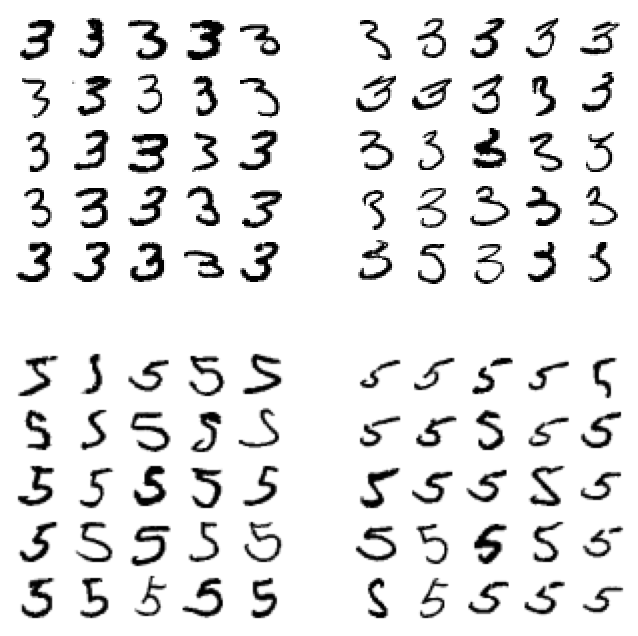

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

=> 대부분의 잘못 분류된 이미지는 확실히 에러인 것 같고, 분류기가 실수한 이유를 이해하기 어려움.

=> 원인: 선형 모델인 SGDClassifier를 사용했기 때문

> 선형 분류기: 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산. 따라서 3과 5는 몇 개의 픽셀만
다르기 때문에 모델이 쉽게 혼동함.

분류기는 이미지의 위치나 회전 방향에 매우 민감하다.

=> 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리 해 에러 줄인다.

## 3.6 다중 레이블 분류
---

다중 레이블 분류 시스템: 여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# 각 숫자 이미지에 두 개의 타킷 레이블이 담긴 y_multilabel 배열 만들기
## 첫 번째는 순자가 큰 값(7,8,9)인지, 두 번째는 홀수인지 나타냄.
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

# KNeighborsClassifier 인스턴스를 만들고, 다중 타킷 배열을 사용하여 훈련시킴
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
# 예측을 만들면 두 개의 레이블 출력
knn_clf.predict([some_digit])  # 올바르게 분류됨(숫자 5는 크지 않고(False), 홀수(True))

array([[False,  True]])

In [ ]:
# 다중 레이블 분류기 평가
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
print(f1_score(y_multilabel, y_train_knn_pred, average="macro"))

0.976410265560605


## 3.7 다중 출력 분류
---

다중 출력 다중 클래스 분류(다중 출력 분류): 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것. (값을 두 개 이상 가질 수 있음).

- 이미지에서 잡음을 제거하는 시스템 만들기

잡음이 많은 숫자 이미지를 입력으로 받고, 깨끗한 숫자 이미지를 픽셀의 강도를 담은 배열로 출력

In [ ]:
# MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에
# 넘파이의 randint() 함수 사용하여 픽셀 강도에 잡음 추가
## 타깃 이미지는 원본 이미지
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

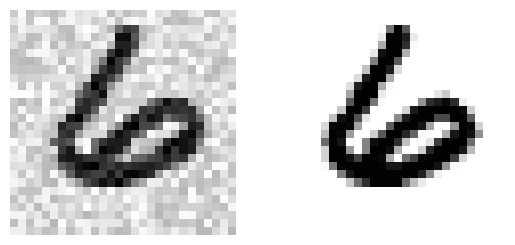

In [ ]:
# 테스트 세트에서 이미지 하나 선택
some_index = 5501
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

=> 왼쪽이 잡음 섞인 이미지, 오른쪽이 깨끗한 타깃 이미지

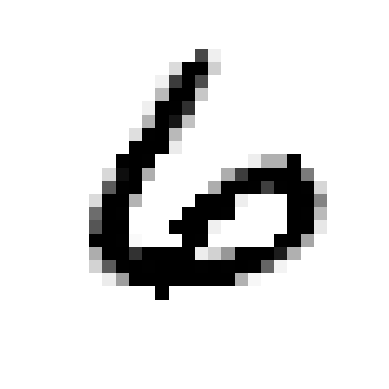

In [ ]:
# 분류기를 훈련시켜 이 이미지를 깨끗하게 만들어보기
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

=> 타깃과 매우 비슷!